In [157]:
from datetime import datetime
import requests as req
from typing import List
import requests as req
from statistics import mean
from dtw import *

In [158]:
class ChartCollectorAPI():
    def __init__(self):
        self.charts={}
    
    def get_chart(self,symbol:str,charts:List[str]=None,range:str="1mo") -> list:
        headers = {
            'x-api-key': "mTd2MNVwEe3WFgj5PQ66Tbpq0CyeP8Q7ESjpmYZ2"
        }
        
        url = f"https://yfapi.net/v8/finance/chart/{symbol}?comparisons="
        if charts:
            for asset in charts:
                url+= asset
                if asset != (len(charts) - 1):
                    url+="%2C"
        
        url+=f"&range={range}&region=US&interval=1d&lang=en&events=div%2Csplit"
        
        response = req.request("GET", url, headers=headers)
        
        try:
            response = response.json()["chart"]["result"][0]
            timesamps = response["timestamp"]
            
            reference = response["indicators"]["quote"][0]["close"]
            
            # Adding reference chart
            if symbol not in self.charts and None not in reference:
                self.charts[symbol]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, reference)]
            
            
            if charts:
                comparison = response["comparisons"]
                # Adding the comparisons charts
                for value in comparison:
                    if value["symbol"] not in self.charts and None not in value["close"]:
                        self.charts[value["symbol"]]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, value["close"])]


            
        
        except Exception as error:
            print(response.json())
        
        
    """
    Methode pour charger le graphique d'un actif depuis l'api
    On verifie si l'actif n'a pas encore été chargé
    """
    def loading(self,list_actifs:List[str]):
        for actif in list_actifs:
            if actif not in self.charts:
               self.charts[actif]=self.get_chart(actif)
        
    """Methode qui sauvegarde les differents graphiques de comparaisons des différents actifs passés dans une liste en parametre
    Print dans la console les differentes distances en fonction de l'algorithme utilisé.
    """
    def resultats_rapports(self,actif_reference,charts) -> dict:
        results = {}
        
        
        
        chart_reference = [value['close'] for value in charts[actif_reference]]
        date_reference = charts[actif_reference][-1]['date']
        
        # Les données mensuelles sont de taille 21 normalement 
        data_length = 21
        
        # Le graphique de reference correspond au dernier mois
        chart_reference = chart_reference[-data_length:]
        

        # On le compare aux autres graphiques
        for actif_comparaison in charts:
            if actif_comparaison != actif_reference:
                
                # On recupere les données de comparaison
                chart_comparison = [value['close'] for value in charts[actif_comparaison]]
                dates_comparison = [value['date'] for value in charts[actif_comparaison]]
                
                if(len(chart_comparison) > 200):
                    
                    
                    # On va réduire la fenetre des actifs de comparaison afin d'être au plus proche de notre strategie
                    # On enleve le dernier mois et on garde les autres mois
                    comparison_charts = [chart_comparison[:-data_length*2][x:x+data_length] for x in range(0, len(chart_comparison[:-data_length*2]), data_length)]
                    
                    comparison_date = [dates_comparison[:-data_length][x:x+data_length] for x in range(0, len(dates_comparison[:-data_length]), data_length)]
                    
                    
                    # On va réduire la fenetre des actifs de comparaison afin d'être au plus proche de notre strategie
                    # On enleve le premier mois et on garde les autres mois
                    reality_charts = [chart_comparison[data_length-1:-data_length][x:x+data_length] for x in range(0, len(chart_comparison[data_length-1:-data_length]), data_length)]
                    
                    
                    
                    
                    
                    # Comparison correspond à un mois en partant du premier jusqu'à l'avant dernier, et current correspond au mois d'apres
                    for comparison,current_data,date in zip(comparison_charts,reality_charts,comparison_date):
                        
                        # Si les deux graphiques n'ont pas la meme taille cela implique que l'on n'a pas exactement 21 jours dans le mois
                        if (len(comparison) ==len(chart_reference)):
                            try:
                                distance = self.distance_point_par_point_rapport_moyenne(chart_reference,comparison)["distance moyenne"]
                            except Exception as error:
                                print(f"Erreur sur le rapport moyenne {actif_reference} /  {actif_comparaison} : {error} ")
                                raise error
                                
                            results[f"DTW rapport moyenne {actif_reference} /  {actif_comparaison} "] = {
                                "value":distance,
                                "actif_reference":actif_reference,
                                "actif_comparaison":actif_comparaison,
                                "chart_reference":chart_reference,
                                "current_data_comparison":current_data,
                                "current_data_reference":chart_reference[-data_length:],
                                "chart_comparison":comparison,
                                "date_reference":date_reference,
                                "date_comparison":date[0],
                                }
                    
                    
            

            
        
        return results                



    
    def distance_point_par_point_rapport_moyenne(self,chart_reference,chart_comparison):          
         # Adapte les amplitudes des courbes pour pouvoir les comparer
        
        ## On les ramene à 1 en faisant le rapport par rapport à leur moyenne
        try:
            rearange_reference = [value / mean(chart_reference) for value in chart_reference]
        except:
            print(chart_reference)
        try:
            rearange_comparison = [value / mean(chart_comparison) for value in chart_comparison]
        except:
            print(chart_comparison)

        # On calcule les differentes distances entre les points des deux courbes
        distances = [
            abs(rearange_reference[i] - rearange_comparison[i])
            for i in range(len(rearange_reference))
        ]

        return {"distance moyenne":round(mean(distances),2)}
    

    
    def dynamic_time_warping_par_rapport_moyenne(self,chart_reference,chart_comparison):
        # Adapte les amplitudes des courbes pour pouvoir les comparer
        
        ## On les ramene à 1 en faisant le rapport par rapport à leur moyenne
        rearange_reference = [value / mean(chart_reference) for value in chart_reference]
        rearange_comparison = [value / mean(chart_comparison) for value in chart_comparison]


        # OO method call chain
        warping = dtw(rearange_comparison, rearange_reference, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))

        
        return {"distance moyenne":round(warping.distance/len(chart_comparison),2)}
    


https://yfapi.net/v8/finance/chart/AAPL?comparisons=MSFT%2CAPPL&range=1mo&region=US&interval=1d&lang=en&events=div%2Csplit

On charge le plus grand nombre d'actifs possibles

In [159]:
Charts = ChartCollectorAPI()

assets =[  
"MULN",
"SNDL",
"DRCT",
"NIO",
"HYMC",
"AMD",
"TLRY",
"AMC",
"AAPL",
"ADGI",
"AKBA",
"BRQS",
"MU",
"CLVR",
"NAOV",
"SOFI",
"NILE",
"ITUB",
"IMPP",
"SWN",
"DIDI",
"NVDA",
"RMO",
"BEKE",
"HOOD",
"BAC",
"VALE",
"CEI",
"DNA",
"SXTC",
"PLTR",
"NLY",
"WFC",
"BBIG",
"PBR",
"TELL",
"AAL",
"BABA",
"MSFT",
"PFE",
"EDU",
"BBD",
"OXY",
"TME",
"NOK",
"FB",
"NLSN",
"CCL",
"INTC",
"TMC",
"VYNT",
"SIRI",
"CHWY",
"UBER",
"TEVA",
"XOM",
"IBN",
"LCID",
"RIG",
"ISIG",
"AFRM",
"KGC",
"ZSAN",
"MEIP",
"CSCW",
"RIVN",
"RBLX",
"TSLA",
"GERN",
"ZNGA",
"XELA",
"XPEV",
"FCEL",
"FAMI",
"CALA",
"DKNG",
"PLUG",
"LAC",
"WWR",
"MRO",
"SNAP",
"PYPL",
"KMI",
"CLF",
"CSCO",
"TWTR",
"PROG",
"PDD",
"CENN",
"NKLA",
"CMCSA"]

In [160]:
assets_lists = [assets[x:x+10] for x in range(0, len(assets), 10)]

for asset in assets_lists:
    Charts.get_chart(symbol=asset[0],charts=asset[1:],range="1y")

In [165]:
for value in Charts.charts:
    print(value)

MULN
SNDL
HYMC
NIO
AMD
AKBA
MU
SOFI
CLVR
BRQS
NAOV
DIDI
NVDA
BEKE
BAC
RMO
PLTR
BBIG
PBR
WFC
TELL
NLY
EDU
OXY
BBD
NOK
FB
TME
VYNT
XOM
CHWY
TEVA
SIRI
UBER
AFRM
KGC
MEIP
CSCW
ZSAN
XELA
XPEV
DKNG
FCEL
FAMI
CALA
SNAP
PYPL
CSCO
KMI
TWTR
CLF
CMCSA


In [162]:
for chart in Charts.charts:
    print(f"{chart} : length dates = {len(Charts.charts[chart])} ")

MULN : length dates = 254 
SNDL : length dates = 254 
HYMC : length dates = 254 
NIO : length dates = 254 
AMD : length dates = 254 
AKBA : length dates = 254 
MU : length dates = 254 
SOFI : length dates = 254 
CLVR : length dates = 254 
BRQS : length dates = 254 
NAOV : length dates = 254 
DIDI : length dates = 191 
NVDA : length dates = 191 
BEKE : length dates = 191 
BAC : length dates = 191 
RMO : length dates = 191 
PLTR : length dates = 254 
BBIG : length dates = 254 
PBR : length dates = 254 
WFC : length dates = 254 
TELL : length dates = 254 
NLY : length dates = 254 
EDU : length dates = 254 
OXY : length dates = 254 
BBD : length dates = 254 
NOK : length dates = 254 
FB : length dates = 254 
TME : length dates = 254 
VYNT : length dates = 254 
XOM : length dates = 254 
CHWY : length dates = 254 
TEVA : length dates = 254 
SIRI : length dates = 254 
UBER : length dates = 254 
AFRM : length dates = 254 
KGC : length dates = 254 
MEIP : length dates = 254 
CSCW : length dates

Maintenant que nous avons recuperé les données, on va regarder celle qui ressemble le plus à AAPL

In [166]:
Analysis = ChartCollectorAPI()

In [171]:
analysis = Analysis.resultats_rapports("WFC",Charts.charts)

In [ ]:
print(len(analysis))

50


Find the best match

In [172]:
dictionnary = {}
lowest = 1


for value in analysis:
    if (analysis[value]["value"]<lowest):
        lowest = analysis[value]["value"]
        best_choice = analysis[value]

print(best_choice)


{'value': 0.02, 'actif_reference': 'WFC', 'actif_comparaison': 'KMI', 'chart_reference': [51.24, 48.79, 45.81, 46.46, 49.16, 49.01, 48.47, 49.86, 50.11, 51.6, 51.48, 51.42, 51.14, 53.39, 51.12, 51.33, 52.56, 51.81, 51.6, 50.11, 49.61], 'current_data_comparison': [17.48, 17.2, 17.36, 17.41, 17.41, 17.27, 17.35, 17.46, 17.29, 17.37, 17.2, 17.54, 17.19, 17.01, 17.13, 16.76, 16.6, 16.54, 16.77, 16.67, 17.07], 'current_data_reference': [51.24, 48.79, 45.81, 46.46, 49.16, 49.01, 48.47, 49.86, 50.11, 51.6, 51.48, 51.42, 51.14, 53.39, 51.12, 51.33, 52.56, 51.81, 51.6, 50.11, 49.61], 'chart_comparison': [15.83, 15.8, 15.86, 16.35, 16.58, 16.67, 17.02, 17.27, 17.43, 17.61, 17.65, 17.57, 17.89, 17.7, 17.43, 17.43, 17.37, 17.32, 17.5, 17.52, 17.48], 'date_reference': datetime.datetime(2022, 3, 31, 17, 11), 'date_comparison': datetime.datetime(2021, 12, 29, 15, 30)}


In [175]:
current_data_comparison = best_choice["current_data_comparison"]
current_data_reference = best_choice["current_data_reference"]
chart_comparison = best_choice["chart_comparison"]
chart_reference = best_choice["chart_reference"]

prediction = current_data_comparison[len(current_data_comparison)-1]/mean(chart_comparison)*mean(chart_reference)

print(f"Premier jour du mois de l'actif de comparaison : {best_choice['date_comparison']}")
print(f"Dernier jour du mois de l'actif de reference : {best_choice['date_reference']}")
print(f"Predicted price : [{prediction*1.05},{prediction*0.95}]   / Real price : {current_data_reference[-1]}")

Premier jour du mois de l'actif de comparaison : 2021-12-29 15:30:00
Dernier jour du mois de l'actif de reference : 2022-03-31 17:11:00
Predicted price : [52.68495290581161,47.667338343353364]   / Real price : 49.61


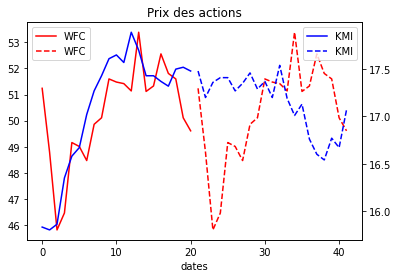

In [174]:
from pandas import DataFrame
import matplotlib.pyplot as plt


# On créé une nouvelle figure pour afficher le premier graphique
plt.Figure(figsize=(5,5), dpi=100)
ax = plt.subplot(111)
ax.yaxis.label.set_color('red')
# On recupere les dates et les prix de l'actif 1
dates = [index for index in range(len(best_choice["chart_reference"]))]
prix = best_choice["chart_reference"]
# On crée un DataFrame pendant pour le plot plus facilement
df = DataFrame({"dates":dates,best_choice["actif_reference"]:prix},columns=[best_choice["actif_reference"],'dates'])
# On regroupe les prix par dates
df = df[['dates',best_choice["actif_reference"]]].groupby('dates').sum()
# On affiche le dataframe
df.plot(kind='line', legend=True, ax=ax, color='r')


# On recupere les dates et les prix de l'actif 1 ce qui s'est reellement passé 
prix = best_choice["current_data_reference"]
dates = [index for index in range(len(best_choice["chart_reference"]),len(best_choice["chart_reference"])+len(best_choice["chart_reference"]))]
# On crée un DataFrame pendant pour le plot plus facilement
df = DataFrame({"dates":dates,best_choice["actif_reference"]:prix},columns=[best_choice["actif_reference"],'dates'])
# On regroupe les prix par dates
df = df[['dates',best_choice["actif_reference"]]].groupby('dates').sum()
# On affiche le dataframe
df.plot(linestyle='dashed',kind='line', legend=True, ax=ax, color='r')




# On decoupe les ordonnées en deux categories distinctes pour les visualiser correctement
ax2 = ax.twinx()
# On change la couleur du label des ordonnées
ax2.yaxis.label.set_color('b')

# On recupere les dates et les prix de l'actif 2
prix = best_choice["chart_comparison"]
# On recupere les dates et les prix de l'actif 2
dates = [index for index in range(len(best_choice["chart_comparison"]))]
# On crée un DataFrame pendant pour le plot plus facilement
df = DataFrame({"dates":dates,best_choice["actif_comparaison"]:prix},columns=[best_choice["actif_comparaison"],'dates'])
# On regroupe les prix par dates
df = df[['dates',best_choice["actif_comparaison"]]].groupby('dates').sum()
# On affiche le dataframe
df.plot(kind='line', legend=True, ax=ax2, color='b')


# On recupere les dates et les prix de l'actif 2 ce qui s'est reellement passé 
prix = best_choice["current_data_comparison"]
dates = [index for index in range(len(best_choice["chart_reference"]),len(best_choice["chart_reference"])+len(best_choice["chart_reference"]))]
# On crée un DataFrame pendant pour le plot plus facilement
df = DataFrame({"dates":dates,best_choice["actif_comparaison"]:prix},columns=[best_choice["actif_comparaison"],'dates'])

# On regroupe les prix par dates
df = df[['dates',best_choice["actif_comparaison"]]].groupby('dates').sum()
# On affiche le dataframe
df.plot(linestyle='dashed',kind='line', legend=True, ax=ax2, color='b')

ax.set_title('Prix des actions')

plt.show()